In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import matplotlib.pyplot as plt    
import pathlib
import pickle
from pathlib import Path

import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
from ipywidgets.widgets import HBox, VBox, Label

sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from local_utils import *

In [2]:
def loss_u(pattern, D_u, rho_u, sigma_u, mu_u, kappa_u, 
          u, u_xx, u_yy, u_t, v):
        
    f = u * u * v / (1.0 + kappa_u * u * u)
    f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u - u_t
    return np.sum(f_u**2)

def loss_v(pattern, D_v, rho_v, sigma_v, kappa_u,
           v, v_xx, v_yy, v_t, u):    
        
    f = u * u * v / (1.0 + kappa_u * u * u)
    f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v - v_t
    
    return np.sum(f_v**2)

def loss(pattern, D_u, D_v, rho_u, sigma_u, mu_u, kappa_u, rho_v, sigma_v,
         u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t ):
    return (loss_u(pattern, D_u, rho_u, sigma_u, mu_u, kappa_u,
                   u, u_xx, u_yy, u_t, v) +
            loss_v(pattern, D_v, rho_v, sigma_v, kappa_u, v,
                    v_xx, v_yy, v_t, u))



In [5]:
pattern = None
x_slice = None
y_slice = None
def load_domain(simulation_name, x_range=(30, 65), y_range=(50, 85), steps=10, title_1="u", title_2="v"):
    disable_all_ranges(True)
    def plot_d(d, title_1="u", title_2="v"):
        x = np.arange(0, d[0,:,:, -1].T.shape[0])[x_slice]
        y = np.arange(0, d[0,:,:, -1].T.shape[1])[y_slice]
        X, Y = np.meshgrid(x, y, indexing='ij')
        _ = plt.figure(figsize=(8,4))
        plt.subplot(121)
        plt.title(f"{title_1}")
        plt.imshow(d[0,:,:, -1].T, origin='lower')
        plt.colorbar(shrink=.75)
        plt.scatter(X, Y, alpha=.5)
        plt.subplot(122)
        plt.title(f"{title_2}")
        plt.imshow(d[1,:,:, -1].T, origin='lower')
        plt.colorbar(shrink=.75)
        plt.scatter(X, Y, alpha=.5)    
        plt.show()
        
    
    x_slice=slice(x_range[0],x_range[1],steps)
    y_slice=slice(y_range[0],y_range[1],steps)    
    pattern = load(simulation_name, 
                   x_slice,
                   y_slice,
                   data_time_start=-3, 
                   data_time_len=2,
                   data_time_step=1,
                   verbose=False)
    globals()["y_slice"] = y_slice
    globals()["x_slice"] = x_slice
    globals()["pattern"] = pattern
    plot_d(pattern.c_domain, title_1="u", title_2="v")
    plot_d(pattern.c_xx_domain, title_1="u_xx", title_2="v_xx")
    plot_d(pattern.c_yy_domain, title_1="u_yy", title_2="v_yy")
    plot_d(pattern.c_t_domain, title_1="u_t", title_2="v_t")
    disable_all_ranges(False)
    return pattern


folders = !ls ~/test/outputs_Koch_Meinhardt_100_by_100

w_simulations = widgets.Dropdown(
    options=folders,
    value="Koch_Meinhardt_1",
    description='Simulation:',
)

w_x_range = widgets.IntRangeSlider(
    value=[0, 99],
    min=0,
    max=99,
    step=1,
    description='X range:',
    continuous_update=False,
)

w_y_range = widgets.IntRangeSlider(
    value=[0, 99],
    min=0,
    max=99,
    step=1,
    description='Y range:',
    continuous_update=False,
)
w_steps = widgets.IntSlider(
    value=10,
    min=1,
    max=20,
    step=1,
    description='Steps:',
    continuous_update=False,
)
def disable_all_ranges(value):
    w_x_range.disabled = value
    w_y_range.disabled = value
    w_steps.disabled = value
    w_simulations.disabled = value
    
w_domain_plot = widgets.interactive_output(load_domain, 
                                    {'simulation_name':w_simulations,
                                     'x_range': w_x_range,
                                     'y_range':w_y_range,
                                    'steps':w_steps})

h_box_range = HBox([w_steps, w_x_range, w_y_range])
hbox_load = HBox([w_simulations])
hbox_domain = HBox([w_domain_plot])
vbox_load = VBox([h_box_range, hbox_load, hbox_domain])
display(vbox_load)

In [ ]:
def plot_losses(u_line_alphas, u_line_losses, u_line_params,
                v_line_alphas, v_line_losses, v_line_params,
                all_line_alphas, all_line_losses, all_line_params,
                u_line_losses_noise=None,  v_line_losses_noise=None, 
                all_line_losses_noise=None,
                log_scale=False):
    fig = plt.figure(figsize=(12,12))
    gs = fig.add_gridspec(2, 2)
    ax = fig.add_subplot(gs[0, 0])
    ax.plot(u_line_alphas, u_line_losses, label="Loss")
    ax.scatter(0, np.min(u_line_losses),c='red', marker='x')
    plt.vlines(0, np.min(u_line_losses), np.max(u_line_losses), color='red' , alpha=.3)
    if u_line_losses_noise is not None:
        ax2 = ax.twinx()
        if log_scale:
            ax2.set_yscale('log')
        ax2.plot(u_line_alphas, u_line_losses_noise, color='orange', label="Noisy loss")
    
    
    ax.set_title("U loss")
    ax.set_ylabel("loss")

    steps = 200
    ax.set_xticks(u_line_alphas[::steps])
    #alpha_labels = [f"{a:.3f}" for a in u_line_alphas[::steps]]
    rho_u_labels = [f"{a:.3f}" for a in u_line_params[::steps, 0]]
    sigma_u_labels = [f"{a:.3f}" for a in u_line_params[::steps, 1]]
    mu_u_labels = [f"{a:.3f}" for a in u_line_params[::steps, 2]]
    kappa_u_labels = [f"{a:.3f}" for a in u_line_params[::steps, 3]]
    u_labels = [ f"{p1}\n{p2}\n{p3}\n{p4}" 
        for p1,p2,p3,p4 in zip(rho_u_labels, sigma_u_labels, mu_u_labels, kappa_u_labels)]
    ax.set_xticklabels(u_labels, rotation=0)
    ax.set_xlabel(r"$\rho_u$" "\n" r"$\sigma_u$" "\n" r"$\mu_u$" "\n" r"$\kappa_u$")
    if log_scale:
        ax.set_yscale('log'); 
    plt.grid(); plt.legend()
    
    
    ax = fig.add_subplot(gs[0, 1])
    ax.plot(v_line_alphas, v_line_losses, label="Loss")
    ax.scatter(0, np.min(v_line_losses),c='red', marker='x')
    plt.vlines(0, np.min(v_line_losses), np.max(v_line_losses), color='red' , alpha=.3)
    if v_line_losses_noise is not None:
        ax2 = ax.twinx()
        if log_scale:
            ax2.set_yscale('log')
        ax2.plot(v_line_alphas, v_line_losses_noise, color='orange', label="Noisy loss")
        
        
    ax.set_title("V loss")
    ax.set_ylabel("loss")
    steps = 200
    ax.set_xticks(v_line_alphas[::steps])
    #alpha_labels = [f"{a:.3f}" for a in v_line_alphas[::steps]]
    rho_v_labels = [f"{a:.3f}" for a in v_line_params[::steps, 0]]
    sigma_v_labels = [f"{a:.3f}" for a in v_line_params[::steps, 1]]
    kappa_u_labels = [f"{a:.3f}" for a in v_line_params[::steps, 2]]
    v_labels = [ f"{p1}\n{p2}\n{p3}" 
        for p1,p2,p3 in zip(rho_v_labels, sigma_v_labels, kappa_u_labels)]
    ax.set_xticklabels(v_labels, rotation=0)
    ax.set_xlabel(r"$\rho_v$" "\n" r"$\sigma_v$" "\n" r"$\kappa_u$")
    if log_scale:
        ax.set_yscale('log');         
    plt.grid();plt.legend();
    
    ax = fig.add_subplot(gs[1, :])
    ax.plot(all_line_alphas, all_line_losses, label="Loss")
    ax.scatter(0, np.min(all_line_losses),c='red', marker='x')
    plt.vlines(0, np.min(all_line_losses), np.max(all_line_losses), color='red' , alpha=.3)
    if all_line_losses_noise is not None:
        ax2 = ax.twinx()
        if log_scale:
            ax2.set_yscale('log')
        ax2.plot(all_line_alphas, all_line_losses_noise, color='orange', label="Noisy loss")
        
    ax.set_title("Loss")
    ax.set_ylabel("loss")
    
    ax.set_xticks(all_line_alphas[::steps])    
    all_labels = [ f"{p1}\n{p2}\n{p3}\n{p4}\n{p5}\n{p6}" 
        for p1,p2,p3,p4,p5,p6 in zip(rho_u_labels, sigma_u_labels, mu_u_labels, kappa_u_labels,
                                     rho_v_labels, sigma_v_labels)]
    ax.set_xticklabels(all_labels, rotation=0)
    ax.set_xlabel(r"$\rho_u$" "\n" r"$\sigma_u$" "\n" r"$\mu_u$" "\n" r"$\kappa_u$"
                  r"$\rho_v$" "\n" r"$\sigma_v$" "\n")
    
    if log_scale:
        ax.set_yscale('log');
    plt.grid();plt.legend();
    
    plt.tight_layout(); plt.show()

In [5]:
def create_ranges(std_factor, extend_factor, zero_left=False):
    u_vec_ac = np.array([pattern.params["rho_u"], pattern.params["sigma_u"],
                         pattern.params["mu_u"], pattern.params["kappa_u"]])

    scale=u_vec_ac*std_factor
    scale[scale==0]=1
    u_vec = np.random.normal(u_vec_ac, scale=scale)
    u_vec = np.abs(u_vec)

    v_vec_ac = np.array([pattern.params["rho_v"], 
                         pattern.params["sigma_v"], pattern.params["kappa_u"]])    

    scale=v_vec_ac*std_factor
    scale[scale==0]=1
    v_vec    = np.random.normal(v_vec_ac, scale=scale)
    v_vec = np.abs(v_vec)
    
    all_vec_ac = np.concatenate([u_vec_ac, v_vec_ac[:-1]])
    
    all_vec = np.concatenate([u_vec, v_vec[:-1]])
    

    s_u = normalise(u_vec - u_vec_ac)
    s_v = normalise(v_vec - v_vec_ac)
    s_all = normalise(all_vec - all_vec_ac)

    s_u_line = creat_line(u_vec_ac, s_u)
    s_v_line = creat_line(v_vec_ac, s_v)
    s_all_line = creat_line(all_vec_ac, s_all)

    alpha_u_end = Euc_L(u_vec - u_vec_ac)
    alpha_v_end = Euc_L(v_vec - v_vec_ac)
    alpha_all_end = Euc_L(all_vec - all_vec_ac)

    #print(f"U params. distance: {Euc_L(u_vec-u_vec_ac)}")
    #print(f"V params. distance: {Euc_L(v_vec-v_vec_ac)}")

    if zero_left:
        u_line_alphas = np.linspace(0, extend_factor*alpha_u_end, 1000)
        v_line_alphas = np.linspace(0, extend_factor*alpha_v_end, 1000)
        all_line_alphas = np.linspace(0, extend_factor*alpha_all_end, 1000)
    else:
        u_line_alphas = np.linspace(-extend_factor*alpha_u_end, extend_factor*alpha_u_end, 1000)
        v_line_alphas = np.linspace(-extend_factor*alpha_v_end, extend_factor*alpha_v_end, 1000)        
        all_line_alphas = np.linspace(-extend_factor*alpha_all_end, extend_factor*alpha_all_end, 1000)

    u_line_params = np.array([ s_u_line(alpha) for alpha in u_line_alphas])
    v_line_params = np.array([ s_v_line(alpha) for alpha in v_line_alphas])
    all_line_params = np.array([ s_all_line(alpha) for alpha in all_line_alphas])
    
    return (u_line_alphas, u_line_params, v_line_alphas, v_line_params,
            all_line_alphas, all_line_params)


def create_and_plot_losses(std_factor=.6, extend_factor=.1, noise=0.0, log_scale=False, zero_left=False):
    (u_line_alphas, u_line_params,
      v_line_alphas, v_line_params,
      all_line_alphas, all_line_params) = create_ranges(std_factor, extend_factor, zero_left)
    
    (u, u_xx, u_yy, u_t,
     v, v_xx, v_yy, v_t) = (pattern.c[0, ...].copy(),
                            pattern.c_xx[0, ...].copy(),
                            pattern.c_yy[0, ...].copy(),
                            pattern.c_t[0, ...].copy(),
                            pattern.c[1, ...].copy(),
                            pattern.c_xx[1, ...].copy(),
                            pattern.c_yy[1, ...].copy(),
                            pattern.c_t[1, ...].copy())
    
    u_line_losses = np.array([loss_u(pattern, pattern.params["D_u"], *params,
                                     u, u_xx, u_yy, u_t, v) for params in u_line_params])
    v_line_losses = np.array([loss_v(pattern, pattern.params["D_v"], *params,
                                     v, v_xx, v_yy, v_t, u) for params in v_line_params])    
    all_line_losses = np.array([loss(pattern, pattern.params["D_u"], pattern.params["D_v"], 
                                     *params,
                                     u, u_xx, u_yy, u_t, 
                                     v, v_xx, v_yy, v_t) for params in all_line_params])            
    
    if noise >0:
        u += np.random.normal(scale=noise*np.abs(u))
        u_xx += np.random.normal(scale=noise*np.abs(u_xx))
        u_yy += np.random.normal(scale=noise*np.abs(u_yy))
        u_t += np.random.normal(scale=noise*np.abs(u_t))
        v += np.random.normal(scale=noise*np.abs(v))
        v_xx += np.random.normal(scale=noise*np.abs(v_xx))
        v_yy += np.random.normal(scale=noise*np.abs(v_yy))
        v_t += np.random.normal(scale=noise*np.abs(v_t))
        
        
        u_line_losses_noise = np.array([loss_u(pattern, pattern.params["D_u"], *params,
                                               u, u_xx, u_yy, u_t, v) for params in u_line_params])
        v_line_losses_noise = np.array([loss_v(pattern, pattern.params["D_v"], *params,
                                               v, v_xx, v_yy, v_t, u) for params in v_line_params])
        all_line_losses_noise = np.array([loss(pattern, pattern.params["D_u"], pattern.params["D_v"], 
                                               *params,
                                               u, u_xx, u_yy, u_t, 
                                               v, v_xx, v_yy, v_t) for params in all_line_params])
    
        plot_losses(u_line_alphas, u_line_losses, u_line_params,
                    v_line_alphas, v_line_losses, v_line_params,
                    all_line_alphas, all_line_losses, all_line_params,
                    u_line_losses_noise, v_line_losses_noise, all_line_losses_noise,
                    log_scale=log_scale)
    else:
        plot_losses(u_line_alphas, u_line_losses, u_line_params,
                    v_line_alphas, v_line_losses, v_line_params, 
                    all_line_alphas, all_line_losses, all_line_params,
                    log_scale=log_scale)

Koch_Meinhardt_1
{'D_u': 0.1, 'D_v': 1.0, 'kappa_u': 0.0, 'rho_u': 0.1, 'mu_u': 1.0, 'sigma_u': 1.0, 'rho_v': 0.025, 'sigma_v': 1.0}


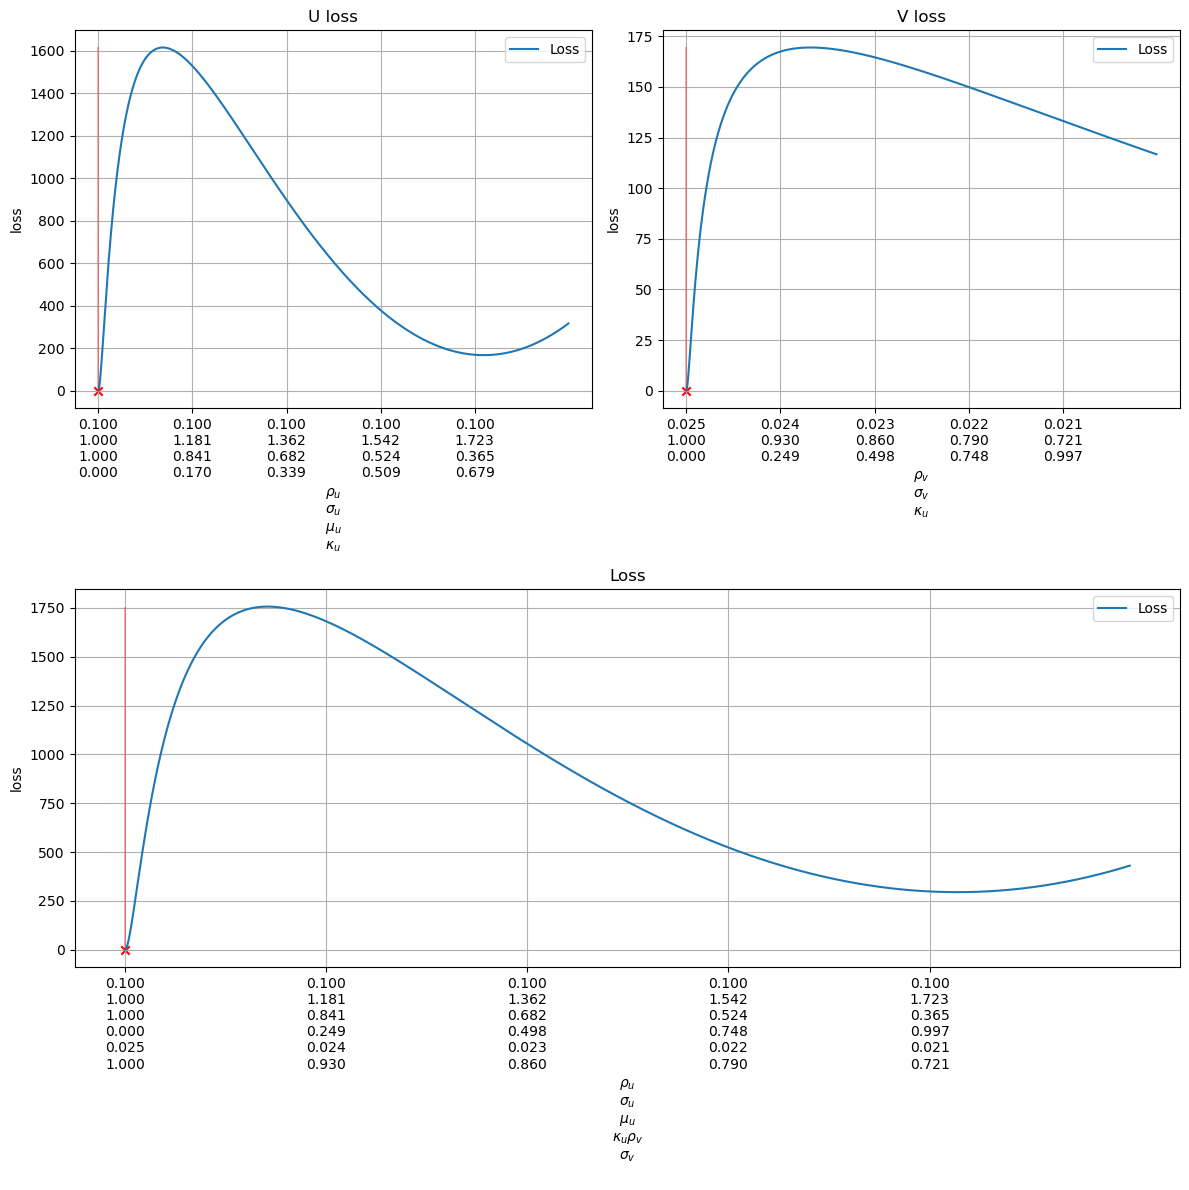

In [6]:
w_std_factor = widgets.FloatSlider(
    value=1.0,
    min=.01,
    max=10,
    step=0.01,
    description='Std factor:',
    continuous_update=False,
)

w_extend_factor = widgets.FloatSlider(
    value=0.1,
    min=.01,
    max=10,
    step=0.01,
    description='range:',
    continuous_update=False,
)

w_noise = widgets.FloatSlider(
    value=0.0,
    min=0,
    max=2,
    step=0.01,
    description='noise:',
    continuous_update=False,
)

w_button_redraw = widgets.Button(
  description="Draw"
)

w_log_scale = widgets.Checkbox(
    value=False,
    description='Log scale',
    disabled=False
)

w_zero_left = widgets.Checkbox(
    value=False,
    description='Zero left',
    disabled=False
)

def disbale_all2(value):
    w_button_redraw.disabled = value
    w_extend_factor.disabled = value
    w_std_factor.disabled = value
    w_log_scale.disabled = value
    w_zero_left.disabled = value
    

def click_redraw(change):
    clear_output(wait=True)
    print(pattern.simulation.name)
    print(pattern.params)
    display(v2box_load)
    disbale_all2(True)
    create_and_plot_losses(w_std_factor.value, w_extend_factor.value, w_noise.value, w_log_scale.value,
                           w_zero_left.value)
    disbale_all2(False)

w_button_redraw.on_click(click_redraw)

print(pattern.simulation.name)
print(pattern.params)
h2_box_range = HBox([w_std_factor, w_extend_factor, w_noise])
h2box_load = HBox([w_zero_left, w_log_scale, w_button_redraw,])
v2box_load = VBox([h2_box_range, h2box_load])
display(v2box_load)